In [6]:
#### Importing Libraries ####

import pandas as pd
import numpy as np
import random
import seaborn as sn
import matplotlib.pyplot as plt

dataset = pd.read_csv('~/Desktop/COVID/Udemy/Udemy Machine learning case studies/Minimize churn rate/P39-Minimizing-Churn-Python-Code/new_churn_data.csv')

In [7]:
## Data Preparation. Dont need user_identifier at teh moment, but we will need them 
#later whn matching the users to the predictions
user_identifier = dataset['user']
dataset = dataset.drop(columns = ['user'])


In [8]:
# One-Hot Encoding to convert categorical variables into their own
# independent binary columns

#find value counts of each of the types of housing
dataset.housing.value_counts()

#use get_dummies function to automatically perform one-hot coding
dataset.groupby('housing')['churn'].nunique().reset_index()
dataset = pd.get_dummies(dataset)
dataset.columns

#as you can see, categories have been broken up into their own binary variables

Index(['churn', 'age', 'deposits', 'withdrawal', 'purchases_partners',
       'purchases', 'cc_taken', 'cc_recommended', 'cc_disliked', 'cc_liked',
       'cc_application_begin', 'app_downloaded', 'web_user', 'ios_user',
       'android_user', 'registered_phones', 'waiting_4_loan', 'cancelled_loan',
       'received_loan', 'rejected_loan', 'left_for_two_month_plus',
       'left_for_one_month', 'reward_rate', 'is_referred', 'housing_O',
       'housing_R', 'housing_na', 'payment_type_Bi-Weekly',
       'payment_type_Monthly', 'payment_type_Semi-Monthly',
       'payment_type_Weekly', 'payment_type_na', 'zodiac_sign_Aquarius',
       'zodiac_sign_Aries', 'zodiac_sign_Cancer', 'zodiac_sign_Capricorn',
       'zodiac_sign_Gemini', 'zodiac_sign_Leo', 'zodiac_sign_Libra',
       'zodiac_sign_Pisces', 'zodiac_sign_Sagittarius', 'zodiac_sign_Scorpio',
       'zodiac_sign_Taurus', 'zodiac_sign_Virgo', 'zodiac_sign_na'],
      dtype='object')

In [9]:
#avoid dummy variable trap which shows correlated counms. eg, if both housing_O
#and housing_R are 0, housing_na automatically becomes 1. So we always need to get rid of
#one of the hot-encoding columns to make sure there is no correlation in the 
#fields. We also dont need Zodiac_na, and payment_type
dataset = dataset.drop(columns = ['housing_na', 'zodiac_sign_na', 'payment_type_na'])

In [10]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

#drop respons variable. We only want X in this data split. declare 'churn' as our Y
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns = 'churn'), dataset['churn'],
                                                    test_size = 0.2,
                                                    random_state = 0)

In [11]:
# Balancing the Training Set for an even ratio (amount of 0's and 1's )
# of test data's response variable
y_train.value_counts()

0    12656
1     8940
Name: churn, dtype: int64

In [12]:
# split he positive and negative values for the response variable into
# its own indexes
pos_index = y_train[y_train.values == 1].index
neg_index = y_train[y_train.values == 0].index

In [13]:
# now make a loop, so if the amount of positive values is > than the number 
# of negative values in the training dataset, randomly select values to get rid of
# from the larger set, to matech that of the smaller one

if len(pos_index) > len(neg_index):
    higher = pos_index
    lower = neg_index
else:
    higher = neg_index
    lower = pos_index

random.seed(0)
higher = np.random.choice(higher, size=len(lower))
# returns an array:

# store the lower values as an array for consistency
lower = np.asarray(lower)

# concatenate lower and higher, to combine the lower and higher indexes (both of which
# are the same size)
new_indexes = np.concatenate((lower, higher))

# assign the even indexes to a new training dataset:
X_train = X_train.loc[new_indexes,]
y_train = y_train[new_indexes]

In [14]:
# Feature Scaling to normalize the data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

# store new datasets as pandas dataframes since StandardScalar returns an np array
# so we lose the index of the rows and the column names:

X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values

# replace original datasets with these new ones
X_train = X_train2
X_test = X_test2

In [15]:
#### Model Building ####


# Fitting Model to the Training Set
from sklearn.linear_model import LogisticRegression

# classification model that we name classifier
classifier = LogisticRegression(random_state = 0)


In [16]:
# Fit the model
classifier.fit(X_train, y_train)

# Predicting Test Set
y_pred = classifier.predict(X_test)

/Users/rajvirbassi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [18]:
# Evaluating Results
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# tp = true positives
# ft = false positives
accuracy_score(y_test, y_pred) # >50 is good for industry purposes


0.6161111111111112

In [19]:
#Of all positives predicted, how many are true 
precision_score(y_test, y_pred) # tp / (tp + fp) 

0.5255799173816333

In [20]:
#Of all actual positives, how many did we predict as true
recall_score(y_test, y_pred) # tp / (tp + fn) 

0.7403760071620412

In [21]:
# f1_score is a better indicator than the above, especially with such different results
f1_score(y_test, y_pred)

0.6147556216316671

Test Data Accuracy: 0.6161


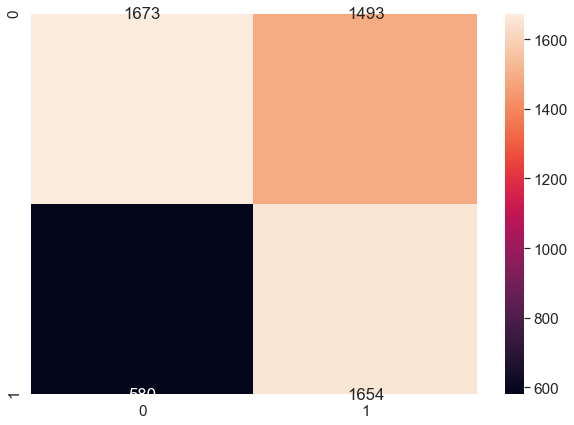

In [22]:
#create a dataframe of the confusion matrix 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

In [23]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score

#create the accuracies for the cross validation. cv arguments is amount of folds we want
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

#get the mean of all the folds accuracies
print("SVM Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))


/Users/rajvirbassi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rajvirbassi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rajvirbassi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rajvirbassi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rajvirbassi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

SVM Accuracy: 0.641 (+/- 0.021)


In [24]:
# Analyzing Coefficients

# create a concatenated df 
pd.concat([pd.DataFrame(X_train.columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])# need to transpose the row to a column
           ],axis = 1)

,features,coef
0,age,-0.161562
1,deposits,0.850073
2,withdrawal,0.051478
3,purchases_partners,-0.719927
4,purchases,-0.969498
5,cc_taken,0.095890
6,cc_recommended,0.030727
7,cc_disliked,-0.021271
8,cc_liked,-0.022293
9,cc_application_begin,0.053614


In [25]:
# looking at the coefficients, in absolute terms we see th at purchase_partners and purchases
# are very high compared to the rest, and will therefore be very important
# in predicting the response variable

In [26]:
#### Feature Selection ####

# getting rid of columns that do not really contribute to the model. This should
# give us the same accuracy and reduce the amount of time it takes the model 
# to run.

In [27]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


In [28]:
# Model to Test
classifier = LogisticRegression()

In [29]:
X_train.shape

(17880, 41)

In [30]:
# 41 columns. but we can shorten this to 20

# Select Best X Features
rfe = RFE(classifier, 20)
rfe = rfe.fit(X_train, y_train)

/Users/rajvirbassi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rajvirbassi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rajvirbassi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rajvirbassi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rajvirbassi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

In [31]:
# summarize the selection of the attributes that are useful using rfe
print(rfe.support_)


[ True  True  True  True  True  True False False False  True False  True
  True False  True False  True  True  True  True  True  True False  True
  True  True False  True False False False False False False False False
 False False False False False]


In [32]:
#This shows which columns are involved in the final result(True) or not(False)

In [34]:
print(rfe.ranking_) # 1=included, rest are ranked by importance in influencing results
X_train.columns[rfe.support_] #tells us which columns are included

[ 1  1  1  1  1  1  7 13 11  1  3  1  1  2  1 10  1  1  1  1  1  1 14  1
  1  1  6  1 20  5 21 15  4 22 19  8 16 17 12  9 18]


Index(['age', 'deposits', 'withdrawal', 'purchases_partners', 'purchases',
       'cc_taken', 'cc_application_begin', 'web_user', 'ios_user',
       'registered_phones', 'cancelled_loan', 'received_loan', 'rejected_loan',
       'left_for_two_month_plus', 'left_for_one_month', 'reward_rate',
       'housing_O', 'housing_R', 'payment_type_Bi-Weekly',
       'payment_type_Semi-Monthly'],
      dtype='object')

In [35]:
# New Correlation Matrix
sn.set(style="white")

# Compute the correlation matrix using the columns that were selected
corr = X_train[X_train.columns[rfe.support_]].corr()


In [37]:
# Fitting Model to the Training Set that we have now created
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train[X_train.columns[rfe.support_]], y_train)


/Users/rajvirbassi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
# Predicting Test Set with the new training set
y_pred = classifier.predict(X_test[X_train.columns[rfe.support_]])

In [39]:
# run everything else as we did before (after cell 16)
# Predicting Test Set
y_pred = classifier.predict(X_test[X_train.columns[rfe.support_]])

Test Data Accuracy: 0.6124


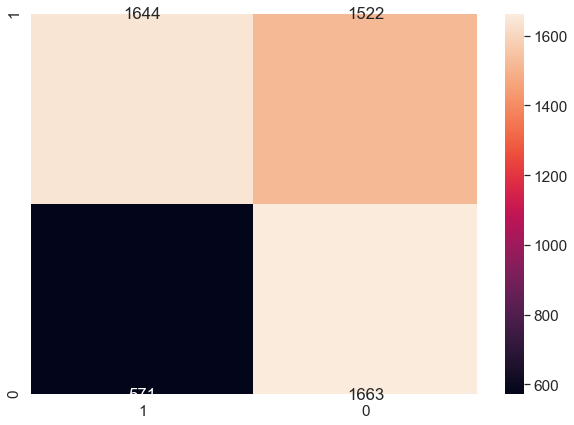

In [40]:
# Evaluating Results
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)
precision_score(y_test, y_pred) # tp / (tp + fp)
recall_score(y_test, y_pred) # tp / (tp + fn)
f1_score(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = (1, 0), columns = (1, 0))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))


In [42]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier,
                             X = X_train[X_train.columns[rfe.support_]],
                             y = y_train, cv = 10)
print("SVM Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))




/Users/rajvirbassi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rajvirbassi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rajvirbassi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rajvirbassi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rajvirbassi/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

SVM Accuracy: 0.643 (+/- 0.020)


In [43]:
# Analyzing Coefficients from the updated data (from rfe.support)
pd.concat([pd.DataFrame(X_train[X_train.columns[rfe.support_]].columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)


,features,coef
0,age,-0.162302
1,deposits,0.840805
2,withdrawal,0.051224
3,purchases_partners,-0.702747
4,purchases,-0.955704
5,cc_taken,0.088465
6,cc_application_begin,0.057504
7,web_user,0.120956
8,ios_user,0.054948
9,registered_phones,0.104293


In [44]:
#### End of Model ####
# We have found 20 columns that dont give us anything new in this data. We wanted 
# attempted to use the columns first, but chopped them off of the dataset and used
# only the columns that are good predictors.


In [45]:
# Formatting Final Results. Assign the result to the user identifier.
final_results = pd.concat([y_test, user_identifier], axis = 1).dropna()

# add a new column for final results on whether or not the person was predicted to churn
final_results['predicted_churn'] = y_pred

# reorder columns for better viewing
final_results = final_results[['user', 'churn', 'predicted_churn']].reset_index(drop=True)

In [46]:
final_results

,user,churn,predicted_churn
0,61353,1.0,1
1,67679,0.0,0
2,21269,0.0,0
3,69531,0.0,1
4,25997,0.0,0
...,...,...,...
5395,22377,0.0,0
5396,24291,1.0,1
5397,23740,0.0,1
5398,47663,1.0,0


In [ ]:
#how to leverage these results in industry: 
#   we dont know WHEN the users will churn.  
#   we can build new features and products to reduce churn
#   we can finetune the model through polls on customers
#   we can finetune the model to predict churn more accurately over a timeframe, 
#      and therefore predict who will churn over that timeframe, rather than just 
#         having a model that tells us who shows syptoms of losing interest in the product